# Model Checking with K-Modules

## Algorithm for simplifying the graph

In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import isomorphism
import itertools
import matplotlib.pyplot as plt
from IPython.display import display
import threading
import random

In [2]:
def is_kmodules(G: nx.classes.graph.Graph, nodes1: list, nodes2: list, testing: bool = False) -> bool:
    '''
    Checks if 2 subgraphs are k-modules
    
    Arguments:
    G: The graph to check
    nodes1: First nodes list 
    nodes2: Second nodes list
    testing: Whether to print steps - used for debugging

    Return:
    bool: Whether the 2 subgraphs are k-modules
    '''
    
    # All nodes and edges
    nodes = G.nodes
    edges = G.edges
    
    # Induced subraphs
    G1 = nx.subgraph(G, nodes1)
    G2 = nx.subgraph(G, nodes2)
    
    
    # Check if the the induced graphs have the same number of vertices
    if(len(nodes1) != len(nodes2)):
        if testing: print('The modules are not of same size of vertices!')
        return False
    
    # Check if the the induced graphs are non-empty
    if(len(nodes1) == 0):
        if testing: print('The modules are empty!')
        return False
    
    # Check if the modules are disjoint
    if(len([n for n in nodes1 if n in nodes2]) > 0):
        if testing: print('The modules are not disjoint!')
        return False
    
    # Check if the the induced graphs have the same number of edges
    if(G1.number_of_edges() != G2.number_of_edges()):
        if testing: print('The modules are not of same size of edges!')
        return False
    

    # Obtain all possible isomorphisms between 2 subgraphs
    GM = isomorphism.GraphMatcher(G1, G2)
    isomorphs = list(GM.isomorphisms_iter())
    
    # If there is no isomorphism
    if(len(isomorphs) == 0):
        if testing: print('The modules are not isomorphic!')
        return False
    
    # Iterate over all isomorphisms to find a matching that satisfies k-modules
    for isomorph in isomorphs:
        satisfies_inner = True
        satisfies_outer = True
        
        # Reordering the modules according to the isomorphism...
        nodes1 = list(isomorph.keys())
        nodes2 = list(isomorph.values())
    
        # Testing the neigboorhood properties...
        # Iterating over the nodes of the first subgraph...
        for id1, node1 in enumerate(nodes1):

            # Checking the neighbourhood properties between the 2 modules...
            inner_nbrs1 = [n for n in G.neighbors(node1) if n in nodes2]

            for nbr in inner_nbrs1:
                # If there is an edge (a_i, b_j) then there should be (a_j, b_i)
                id2 = nodes2.index(nbr)
                if not((nodes1[id2], nodes2[id1]) in edges):
                    if testing: 
                        print('Not satisfying the inner neighbourhood properties')
                        print('Matching: ', isomorph)
                        print('There is', (node1, nbr))
                        print('But no', (nodes1[id2], nodes2[id1]) )

                    satisfies_inner = False


            # Checking the neighbourhood properties outside the 2 modules...
            node2 = nodes2[id1]

            # Outer neighbours
            outer_nbrs1 = [n for n in G.neighbors(node1) if n not in nodes1 and n not in nodes2]
            outer_nbrs2 = [n for n in G.neighbors(node2) if n not in nodes1 and n not in nodes2]

            if(outer_nbrs1 != outer_nbrs2):
                if testing: 
                    print('Not satisfying the outer neighbourhood properties:')
                    print('Matching: ', isomorph)
                    print('Outer neighbours of', node1, ':', outer_nbrs1)
                    print('Outer neighbours of',node2, ':', outer_nbrs2)
                satisfies_outer = False
                
        # If both neighbourhood properties are satisfied then the subgraphs are k-modules
        if satisfies_inner and satisfies_outer:
            if testing: print('Matching: ', isomorph)
            return True
        
    
    # Return False if there is no isomorphism satisfying the neighbourhood properties
    return False

In [3]:
def are_kmodules(G: nx.classes.graph.Graph, M: list) -> bool:
    '''
    Checks if a set of subgraphs are pairwise k-modules
    
    Arguments:
    G: The graph to check
    M: The set of subgraphs (only nodes as a list)

    Return:
    bool: Whether all subgraphs are pairwise k-modules
    '''
    
    # Check if the list is empty
    if (len(M) == 0): return False
    
    # Testing for all unique pairs in M if they are k-modules
    for m1 in range(len(M)):
        for m2 in range(m1 + 1, len(M)):
            
            # If one such pair is found then return False
            if not(is_kmodules(G, M[m1], M[m2])): return False
    
    # Return True if there is no pair that aren't k-modules
    return True

In [4]:
def partition_subgraphs(G: nx.classes.graph.Graph, subgraphs: list) -> list:
  '''
  Partitions a list of subgraphs wrt their number of edges

  Arguments:
  G: The graph to check
  subgraphs: A list of subgraphs in G

  Return:
  subgraphs_partitioned: A list of lists where each list have subgraphs of same number of edges
  '''

  # Create a dictionary to hold the subgraphs grouped by the number of edges
  subgraphs_by_edges = {}

  # Iterate over all subgraphs and group them by the number of edges
  for subgraph in subgraphs:
      num_edges = G.subgraph(subgraph).number_of_edges()  # get the number of edges in the subgraph
      if num_edges not in subgraphs_by_edges:
          subgraphs_by_edges[num_edges] = []  # create a new list for this number of edges if it doesn't exist
      subgraphs_by_edges[num_edges].append(subgraph)  # add the subgraph to the appropriate list
  
  # Sort the dictionary by keys - number of edges
  sorted_subgraphs = dict(sorted(subgraphs_by_edges.items(), reverse=True))

  # Convert the dictionary to a list of lists
  subgraphs_partitioned = list(sorted_subgraphs.values())

  return subgraphs_partitioned

In [5]:
def find_kmodules(G: nx.classes.graph.Graph, k: int, min_size: int) -> list:
    '''
    Finds a set of k-modules in the given graph
    
    Arguments:
    G: The graph to check
    k: Size of each module
    min_size: Minimum number of k-modules the list should have

    Return:
    M: A list of k-modules or an empty list if none found
    '''
    # Return an empty list if G has less vertices than 2k
    if G.number_of_nodes() < 2*k: return []
    
    # Create a list of all possible subgraphs of size k in G -- |V(G)| comb k possibilities
    subgraphs = [list(subgraph) for subgraph in itertools.combinations(G.nodes, k)]
    num_subgraphs = len(subgraphs)
    
    # OPTION 1: Randomly shuffle the array to avoid divergence
    # random.shuffle(subgraphs)
    
    # OPTION 2: Sort the subraphs list by their number of edges descending
    # subgraphs = sorted(subgraphs, key=lambda x: nx.subgraph(G, x).number_of_edges(), reverse=True)

    # OPTION 3: Partition the subraphs list by their number of edges descending into list of lists
    subgraphs_partitioned = partition_subgraphs(G, subgraphs)
    
    # Lambda function that appends the subgraph to the list if they are k-modules - will be used for threading
    append_kmodules = lambda G, M, sg : M.append(sg) if are_kmodules(G, M + [sg]) else None
    
    # Total number of subraphs checked - for printing purposes
    total_checked = 0
    display_id = f"display_{k}"
    display("", display_id=display_id)
    
    # Iterate over subgraph partitions
    for subgraphs in subgraphs_partitioned:

      # Look for each subgraph all possible k-modules
      for i in range(len(subgraphs)):
          sg1 = subgraphs[i]
          M = [sg1]
          
          # Create an empty list of threads
          trds = []
          for j in range(i + 1, len(subgraphs)):
              sg2 = subgraphs[j]
              # Add function call to the threads list and start
              thread = threading.Thread(target=append_kmodules, args=(G, M, sg2))
              trds.append(thread)
              thread.start()

          # Waiting for threads to be finished...
          for trd in trds:
            trd.join()

          # Increase the number of subgraphs checked and print
          total_checked += 1
          progress = total_checked / num_subgraphs
          message = f'Looking for k={k}: {total_checked}/{num_subgraphs} ({progress:.1%})'
          display(message, display_id=display_id, update=True)
                  
          # If M has more subgraphs than the minimum number needed then the set is found
          if len(M) >= min_size:
              return M
        
    return []

In [6]:
def reduce_graph(G: nx.classes.graph.Graph, qr: int, k_max: int = 100) -> nx.classes.graph.Graph:
    '''
    Algorithm for reducing the graph G according to the quantifier rank qr
    
    Arguments:
    G: The graph to check
    qr: Quantifier rank
    k_max: Maximum size of k-modules to look for - used for avoiding long runtimes

    Return:
    G2: Simplified graph
    '''
        
    # Copy the graph
    G2 = nx.Graph()
    G2.add_nodes_from(G.nodes)
    G2.add_edges_from(G.edges)
    
    
    # Start checking for k=1 modules
    k = 1
    
    while k <= G2.number_of_nodes() / (qr + 1) and k <= k_max:
        
        #print(f'Looking for k={k}:', end='')
        
        has_kmodules = True      
        while has_kmodules:
            
            # Checking for k-modules...
            M = find_kmodules(G2, k, min_size=qr+1)
            
            if len(M) == 0:
                # When there is no modules then stop looking for k
                has_kmodules = False
            else:
                # Removing |M| - qr of those from G2
                print(f'Removing {M[qr:]} from {M}')
                to_remove = [node for subgraph in M[qr:] for node in subgraph]
                G2.remove_nodes_from(to_remove)
         
        # Increase the k for the next step
        k += 1
        print('-----------------------------------')
        
    print('')
        
    return G2

## Plotting functions

In [7]:
def draw_graph(G: nx.classes.graph.Graph, planar: bool = False) -> None:
    '''
    Draws a graph
    
    Arguments:
    G: Graph to draw
    planar: Whether to draw in planar form

    Return:
    '''

    # Create a new plot object
    fig = plt.figure(figsize=(12, 6))
    
    # Draw the graph
    if planar:
      nx.draw_planar(G, with_labels=True)
    else:
      nx.draw(G, with_labels=True)

    plt.show()

In [8]:
def draw_graphs(G1: nx.classes.graph.Graph, G2: nx.classes.graph.Graph, qr: int = -1, planar: bool = False) -> None:
    '''
    Draws 2 graphs side to side
    
    Arguments:
    G1: First graph to draw
    G2: Second graph to draw
    qr: Quantifier rank to print
    planar: Whether to draw in planar form

    Return:
    '''
    
    # Create a new plot object
    fig = plt.figure(figsize=(12, 6))
    
    # Draw the graphs
    subax1 = plt.subplot(121)
    if planar:
      nx.draw_planar(G1, with_labels=True)
    else:
      nx.draw(G1, with_labels=True)

    subax2 = plt.subplot(122)
    if planar:
      nx.draw_planar(G2, with_labels=True)
    else:
      nx.draw(G2, with_labels=True)
    
    # Name the plots
    if qr != -1: fig.suptitle(f'An example for quantifier rank qr={qr}')
    subax1.set_title('Original Graph')
    subax2.set_title('Resulting Graph')
    
    # Print the number of removed vertices
    print(f'Removed {G1.number_of_nodes() - G2.number_of_nodes()} vertices')

## Examples

### Basic

'Looking for k=1: 15/15 (100.0%)'

Removing [[16]] from [[1], [16]]
Removing [[10]] from [[6], [10]]
Removing [[13]] from [[9], [13]]
Removing [[12]] from [[11], [12]]
Removing [[15]] from [[14], [15]]
Removing [[19]] from [[18], [19]]
Removing [[22]] from [[21], [22]]
-----------------------------------


'Looking for k=2: 21/21 (100.0%)'

Removing [[5, 11], [17, 18]] from [[4, 6], [5, 11], [17, 18]]
Removing [[8, 9], [20, 21]] from [[7, 14], [8, 9], [20, 21]]
-----------------------------------


'Looking for k=3: 4/35 (11.4%)'

Removing [[3, 7, 14]] from [[2, 4, 6], [3, 7, 14]]
-----------------------------------

Removed 18 vertices


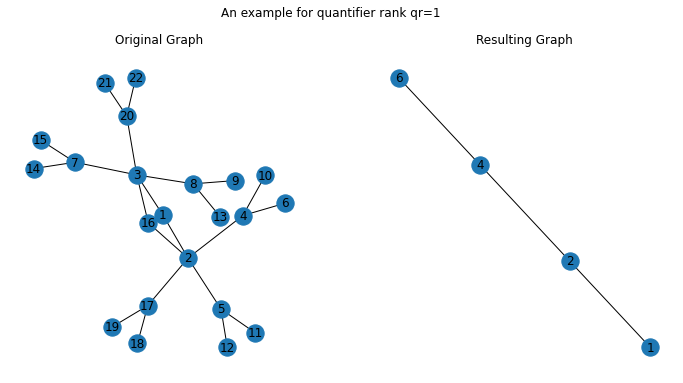

In [12]:
# Create a graph object
G = nx.Graph()

# define list of nodes (node IDs)
nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

# define list of edges
edges = [(1, 2), (1, 3), (16, 2), (16, 3), (2, 4), (2, 5), 
         (4, 6), (4, 10), (5, 11), (5, 12), (2, 17), (17, 18), 
         (17, 19),(3, 7), (3, 8), (8, 9), (8, 13), (7, 14), 
         (7, 15), (3, 20), (20, 21), (20, 22)]

# add information to the graph object
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Call the algorithm to simplify the graph
qr = 1
G2 = reduce_graph(G, qr)

# Draw the graphs and plot
draw_graphs(G, G2, qr)

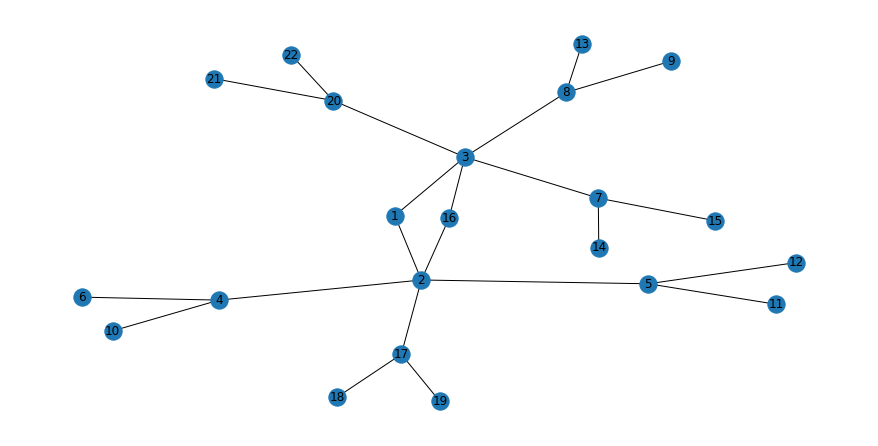

In [14]:
# Create a graph object
G = nx.Graph()

# define list of nodes (node IDs)
nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

# define list of edges
edges = [(1, 2), (1, 3), (16, 2), (16, 3), (2, 4), (2, 5), 
         (4, 6), (4, 10), (5, 11), (5, 12), (2, 17), (17, 18), 
         (17, 19),(3, 7), (3, 8), (8, 9), (8, 13), (7, 14), 
         (7, 15), (3, 20), (20, 21), (20, 22)]

# add information to the graph object
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Call the algorithm to simplify the graph
qr = 2
#G2 = reduce_graph(G, qr)

# Draw the graphs and plot
#draw_graphs(G, G2, qr)
draw_graph(G)

### Complete Graphs

Looking for k=1...
Removing [[2], [3], [4], [5], [6], [7]] from [[0], [1], [2], [3], [4], [5], [6], [7]]
-----------------------------------

Removed 6 vertices


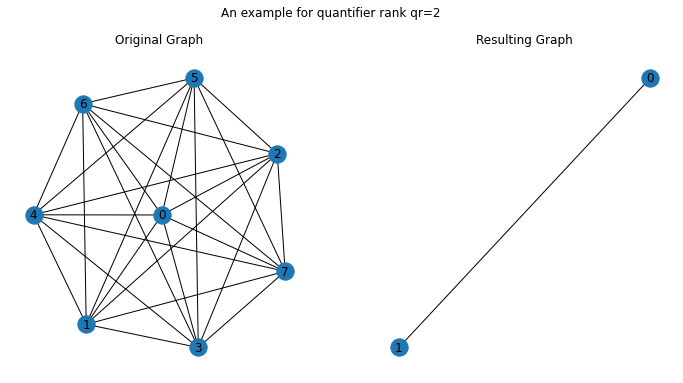

In [ ]:
# Create a graph object
G = nx.complete_graph(8)

# Call the algorithm to simplify the graph
qr = 2
G2 = reduce_graph(G, qr)

# Draw the graphs and plot
draw_graphs(G, G2, qr)

### Trees

In [10]:
def create_tree(h: int, children: list = [], rmv: list = []) -> nx.classes.graph.Graph:
  '''
  Creates a tree in a simple way

  Arguments:
  h: Height of the tree
  children: List of number of children for a parent at each height
  rmv: A list of nodes to remove from the tree

  Returns:
  T: Resulting tree
  '''

  # If children isn't specified then create a random children (0-3) list
  if len(children) == 0:
    children = [random.randint(1,3) for i in range(h)]

  # Check if the number of children corresponds to height
  if len(children) != h:
    raise ValueError("Length of children list doesn't match the height, should be h!")

  # Create the tree
  T = nx.Graph()

  # Create a list of id's of nodes at each height
  nodes_list = [[0]] + [[None]] * (h)
  last_id = 1
  for i in range(1, h+1):
    # Number of nodes and parents for this height
    num_nodes = children[i-1]
    num_parent = len(nodes_list[i-1])

    # Add the lists of id's
    start_id = last_id
    last_id = start_id + (num_nodes * num_parent)
    nodes_list[i] = list(range(start_id, last_id))

  # Add the nodes
  T.add_nodes_from([item for sublist in nodes_list for item in sublist])

  # Add the edges
  for p_id, nodes in enumerate(nodes_list[1:]):
    # Number of parents and children for each parent
    num_parents = len(nodes_list[p_id])
    num_child = int(len(nodes) / num_parents)

    # Children for each parent
    childs_for_parent = [nodes[i:i+num_child] for i in range(0, len(nodes), num_child)]

    # Edges for this height to the parents
    edges = [(parent, node) for id, parent in enumerate(nodes_list[p_id]) for node in childs_for_parent[id]]
    T.add_edges_from(edges)

  # Check if the nodes in rmv exist
  if any([not node in T.nodes for node in rmv]):
    raise ValueError("Node doesn't exist!")

  # Remove the nodes
  T.remove_nodes_from(rmv)

  # Remove the unconnected subgraphs
  if not nx.is_connected(T):
    # Get the largest connected component
    largest_comp = max(nx.connected_components(T), key=len)
    T = nx.induced_subgraph(T, largest_comp)

  return T

Looking for k=1...
Removing [[10], [11], [12]] from [[9], [10], [11], [12]]
Removing [[14], [15], [16]] from [[13], [14], [15], [16]]
Removing [[18], [19], [20]] from [[17], [18], [19], [20]]
Removing [[22], [23], [24]] from [[21], [22], [23], [24]]
Removing [[26], [27], [28]] from [[25], [26], [27], [28]]
Removing [[30], [31], [32]] from [[29], [30], [31], [32]]
-----------------------------------
Looking for k=2...
Removing [[4, 13], [5, 17]] from [[3, 9], [4, 13], [5, 17]]
Removing [[7, 25], [8, 29]] from [[6, 21], [7, 25], [8, 29]]
-----------------------------------
Looking for k=3...
Removing [[2, 6, 21]] from [[1, 3, 9], [2, 6, 21]]
-----------------------------------

Removed 29 vertices


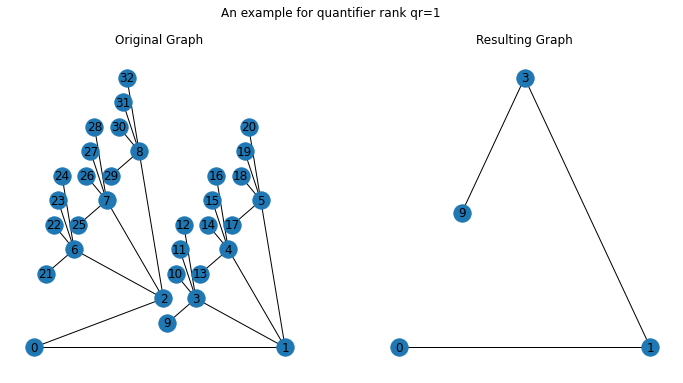

In [ ]:
# Create a balanced tree
G = create_tree(h=3, children=[2,3,4])

# Call the algorithm to simplify the graph
qr = 1
G2 = reduce_graph(G, qr)

# Draw the graphs and plot
draw_graphs(G, G2, qr, planar=True)

'Looking for k=1: 17/17 (100.0%)'

Removing [[17], [18]] from [[16], [17], [18]]
Removing [[20], [21]] from [[19], [20], [21]]
Removing [[23]] from [[22], [23]]
Removing [[26], [27]] from [[25], [26], [27]]
Removing [[29], [30]] from [[28], [29], [30]]
Removing [[35], [36]] from [[34], [35], [36]]
Removing [[38], [39]] from [[37], [38], [39]]
-----------------------------------


'Looking for k=2: 21/21 (100.0%)'

Removing [[5, 19], [6, 22], [7, 25]] from [[4, 16], [5, 19], [6, 22], [7, 25]]
Removing [[10, 34], [11, 37]] from [[8, 28], [10, 34], [11, 37]]
-----------------------------------


'Looking for k=3: 4/35 (11.4%)'

Removing [[2, 8, 28]] from [[1, 4, 16], [2, 8, 28]]
-----------------------------------

Removed 26 vertices


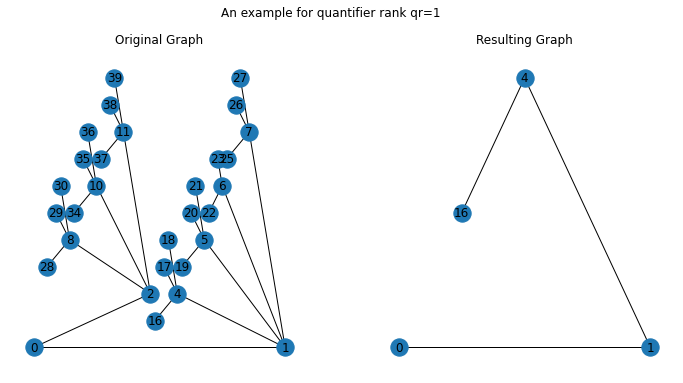

In [13]:
# Create a tree
G = create_tree(h=3, children=[3,4,3], rmv=[3,9,24,45])

# Call the algorithm to simplify the graph
qr = 1
G2 = reduce_graph(G, qr)

# Draw the graphs and plot
#draw_graph(G)
draw_graphs(G, G2, qr, planar=True)

In [ ]:
# Create a tree
G = create_tree(h=3, children=[6,4,3], rmv=[11,15,19,31,35,39,40,41,46,47,49,50,52,53,80,84,87,90,20,101,92,28])

# Call the algorithm to simplify the graph
qr = 2
G2 = reduce_graph(G, qr, k_max=2)

# Draw the graphs and plot
#draw_graph(G)
draw_graphs(G, G2, qr, planar=True)

Looking for k=1...
Removing [[60]] from [[58], [59], [60]]
Removing [[63]] from [[61], [62], [63]]
Removing [[66]] from [[64], [65], [66]]
Removing [[75]] from [[73], [74], [75]]
Removing [[78]] from [[76], [77], [78]]
Removing [[99]] from [[97], [98], [99]]
-----------------------------------
Looking for k=2...
Removing [[14, 54]] from [[12, 48], [13, 51], [14, 54]]


KeyboardInterrupt: ignored

#### Different Heights

Looking for k=1...
Removing [[1]] from [[0], [1]]
-----------------------------------

Removed 1 vertices


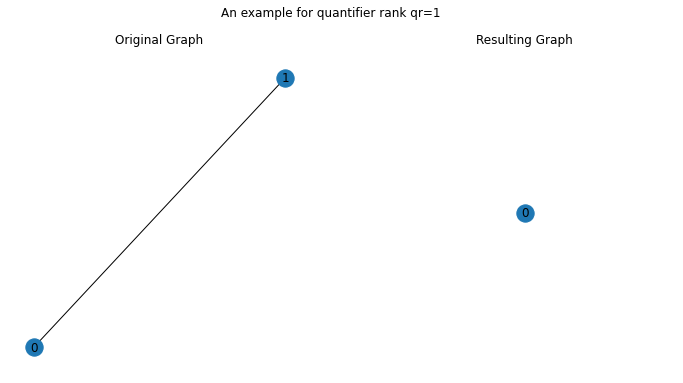

In [ ]:
# Create a tree of height 1
G = create_tree(h=1)

# Call the algorithm to simplify the graph
qr = 1
G2 = reduce_graph(G, qr)

# Draw the graphs and plot
#draw_graph(G)
draw_graphs(G, G2, qr)

Looking for k=1...
-----------------------------------
Looking for k=2...
-----------------------------------
Looking for k=3...
Removing [[3, 8, 9]] from [[1, 4, 5], [2, 6, 7], [3, 8, 9]]
-----------------------------------

Removed 3 vertices


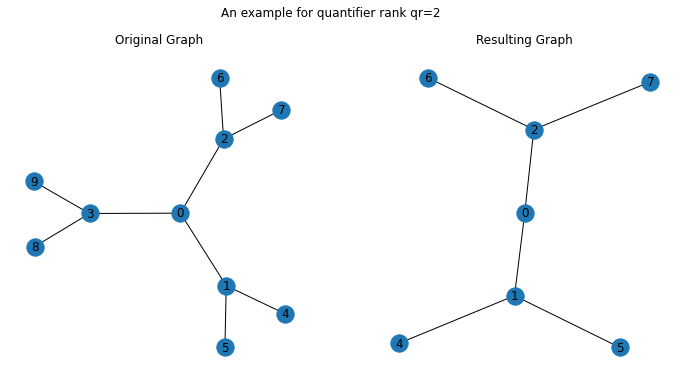

In [ ]:
# Create a tree of height 2
G = create_tree(h=2)

# Call the algorithm to simplify the graph
qr = 2
G2 = reduce_graph(G, qr)

# Draw the graphs and plot
#draw_graph(G)
draw_graphs(G, G2, qr)

Looking for k=1...
Removing [[8], [9]] from [[7], [8], [9]]
Removing [[11], [12]] from [[10], [11], [12]]
Removing [[14], [15]] from [[13], [14], [15]]
-----------------------------------
Looking for k=2...
-----------------------------------
Looking for k=3...
Removing [[2, 5, 10], [3, 6, 13]] from [[1, 4, 7], [2, 5, 10], [3, 6, 13]]
-----------------------------------

Removed 12 vertices


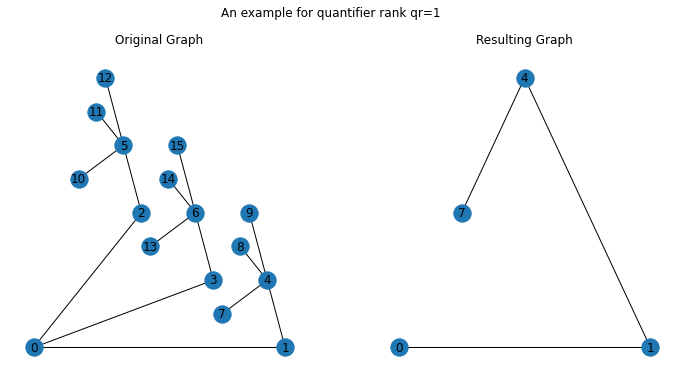

In [ ]:
# Create a tree of height 3
G = create_tree(h=3)

# Call the algorithm to simplify the graph
qr = 1
G2 = reduce_graph(G, qr)

# Draw the graphs and plot
#draw_graph(G)
draw_graphs(G, G2, qr, planar=True)

Looking for k=1...
-----------------------------------
Looking for k=2...
Removing [[6, 12], [7, 13]] from [[5, 11], [6, 12], [7, 13]]
Removing [[9, 15], [10, 16]] from [[8, 14], [9, 15], [10, 16]]
-----------------------------------
Looking for k=3...
-----------------------------------
Looking for k=4...
Removing [[2, 4, 8, 14]] from [[1, 3, 5, 11], [2, 4, 8, 14]]
-----------------------------------

Removed 12 vertices


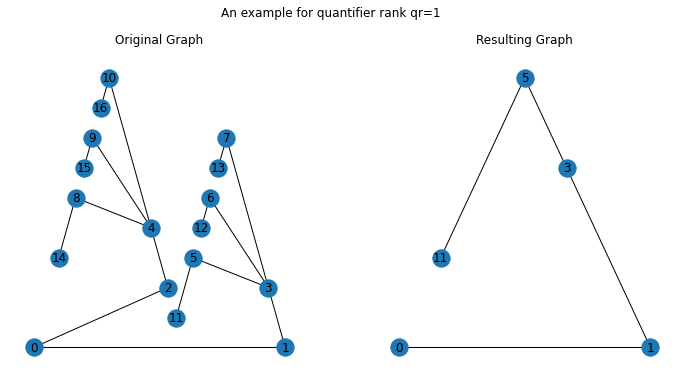

In [ ]:
# Create a tree of height 4
G = create_tree(h=4)

# Call the algorithm to simplify the graph
qr = 1
G2 = reduce_graph(G, qr)

# Draw the graphs and plot
#draw_graph(G)
draw_graphs(G, G2, qr, planar=True)

### K-Partite Graphs

In [ ]:
import random

def create_kpartite(sizes: tuple, complete: bool = False) -> nx.classes.graph.Graph:
  '''
  Creates a k-partite graph in a simple way

  Arguments:
  sizes: A tuple with the sizes of each partition set

  Returns:
  G: Resulting graph
  '''  

  # Create the tree
  G = nx.Graph()

  # Create the nodes list in a list and add to the Graph
  nodes = []
  lastId = 0
  for size in sizes:
    partit = list(range(lastId, lastId + size))
    nodes.append(partit)

    # Add the nodes
    G.add_nodes_from(partit)

    # Increment the lastId for the next iteratiton
    lastId = lastId + size
  
  # Create and add the edges list
  # Generate all possible pairs of lists
  list_pairs = list(itertools.combinations(nodes, 2))

  # Generate all possible tuples of unique elements from the paired lists
  tuples = []
  for pair in list_pairs:
      for elem1 in pair[0]:
          for elem2 in pair[1]:
              if elem1 != elem2:
                  tuples.append(tuple(sorted([elem1, elem2])))

  # Get unique tuples
  unique_tuples = list(set(tuples))

  # Shuffle the list of unique tuples
  random.shuffle(unique_tuples)

  # Cut some of them
  if not(complete):
    cutId = random.randint(0, int(len(unique_tuples)/2))
    unique_tuples = unique_tuples[cutId:]

  # Add the edges
  G.add_edges_from(unique_tuples)
  
  return G

'Looking for k=1: 13/13 (100.0%)'

-----------------------------------


'Looking for k=2: 78/78 (100.0%)'

-----------------------------------


'Looking for k=3: 286/286 (100.0%)'

-----------------------------------


'Looking for k=4: 715/715 (100.0%)'

-----------------------------------

Removed 0 vertices


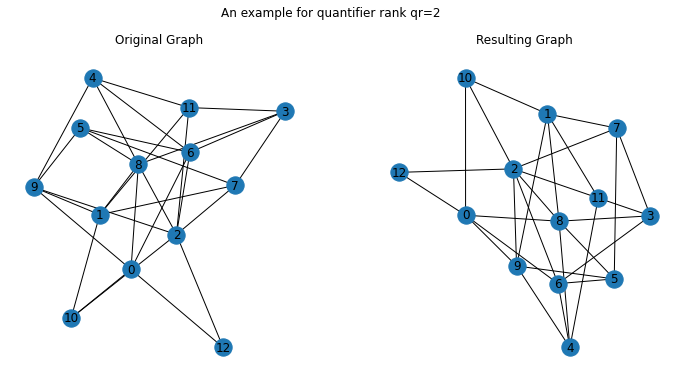

In [ ]:
# Generate a random k-partit graph
G = create_kpartite(sizes=(6,7))

# Call the algorithm to simplify the graph
qr = 2
G2 = reduce_graph(G, qr)

# Draw the graphs and plot
draw_graphs(G, G2, qr)

'Number of tries: 5/50 (10.0%)'

'Looking for k=1: 10/10 (100.0%)'

-----------------------------------


'Looking for k=2: 45/45 (100.0%)'

-----------------------------------


'Looking for k=3: 120/120 (100.0%)'

-----------------------------------


'Looking for k=4: 1001/1001 (100.0%)'

-----------------------------------

-----------------------------------

-----------------------------------

Removing [[10]] from [[7], [9], [10]]
-----------------------------------
-----------------------------------
-----------------------------------

Removed 1 vertices


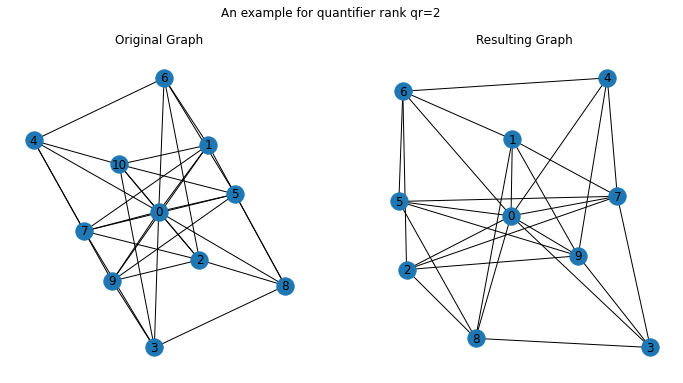

In [ ]:
# Try finding a bipartit graph that gets simplified
max_tries = 50
max_kpartit = 4
max_size = 5
qr = 2

display("", display_id='myDisplay')

for i in range(max_tries):
  # Random sizes
  k = random.randint(1, max_kpartit)
  sizes = tuple(random.randint(1, max_size) for _ in range(k))

  # Generate a random k-partit graph
  G = create_kpartite(sizes)

  # Call the algorithm to simplify the graph
  G2 = reduce_graph(G, qr)

  # Display progress
  progress = (i+1) / max_tries
  message = f'Number of tries: {i+1}/{max_tries} ({progress:.1%})'
  display(message, display_id='myDisplay', update=True)

  # If simplified draw the graphs and plot
  if G2.number_of_nodes() < G.number_of_nodes():
    draw_graphs(G, G2, qr)
    break